In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import dill
import sys
import time
from joblib import Parallel, delayed
import scipy.stats as sct
sys.path.append("modules")
from stn import stnStruct
import deg

In [2]:
inst = "toy2"
with open("../data/"+inst+".dat", "rb") as dill_file:
    stn = dill.load(dill_file)
res = pd.read_pickle("/home/jw3617/STN/results_"+inst+"/lhs/results.pkl")
# res["id"] = res["ID"]
prof = pd.read_pickle("/home/jw3617/STN/results_"+inst+"/lhs/profile.pkl")
prof["taskmode"] = [row["task"] + "-" + row["mode"] for i, row in prof.iterrows()]
prof = prof[prof["id"].isin(res["id"])]
prods = stn.products

In [44]:
def get_hist(df, col):
    table = pd.DataFrame.from_dict(Counter(df[col]), orient="index")
    table = table.rename(columns={0:"count"})
    table["p"] = table["count"]/sum(table["count"])
    print(df.shape)
    return table

def get_trans_prob(df, i, j):
    dfj = df.loc[df["unit"] == j,].copy()
    dfj["taskmode-1"] = dfj["taskmode"].shift(-1)
    dfj.loc[pd.isna(dfj["taskmode-1"]),"taskmode-1"] = "None-None"
    #df = df.loc[df["Product_1"] >= 200]
    #df = df.loc[df["Product_2"] <= 150]
    if np.any(dfj["taskmode"] == i):
        table = get_hist(dfj[dfj["taskmode"] == i], "taskmode-1")
    else:
        table = get_hist(dfj[dfj["taskmode"] == "None-None"], "taskmode-1")
    return table

In [246]:
from sklearn import linear_model
from sklearn.svm import SVC
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from skopt import gp_minimize
from sklearn.preprocessing import MinMaxScaler


def get_logreg_list(prof, c):
    TP = {}
    scr = 0
    ids = np.unique(prof["id"])
    kf = KFold(n_splits=10, shuffle=True)     
    for splt, (train, test) in enumerate(kf.split(ids)):
        df_test = prof[prof["id"].isin(test)]
        df_train = prof[prof["id"].isin(train)]
        for j in stn.units:             
            for i in stn.I[j]:
                for k in stn.O[j]:
                    taskmode = i+"-"+k
                    TP[j, taskmode] = get_logreg(df_train, taskmode, j, c=c)
            taskmode = "None-None"
            TP[j, taskmode] = get_logreg(df_train, taskmode, j, c=c)
            taskmode = "M-M"
            TP[j, taskmode] = get_logreg(df_train, taskmode, j, c=c)
        scr += deg.score(TP, df_test, prods, stn, "../data/toy2.dat", 0.5, 1, 30)
    return TP, scr



def get_logreg(prof, i, j, c=1, cv=False):
    dfj = prof.loc[prof["unit"] == j,].copy()
    dfj["taskmode-1"] = dfj["taskmode"].shift(-1)
    dfj.loc[pd.isna(dfj["taskmode-1"]),"taskmode-1"] = "None-None"
    dfj = dfj[dfj["taskmode"] == i]
    #print(dfj.shape)
    if dfj.shape[0] > 0 and len(np.unique(dfj["taskmode-1"])) > 1:
        ids = np.unique(dfj["id"])
        kf = KFold(n_splits=10, shuffle=True)
        X = np.array(dfj[prods])
        Y = np.array(dfj["taskmode-1"])
        if cv:
            for k, (train, test) in enumerate(kf.split(ids)):
                prof_test = dfj[dfj["id"].isin(test)]
                prof_train = dfj[dfj["id"].isin(train)]
                X_train = prof_train[prods]
                y_train = prof_train["taskmode-1"]
                if len(np.unique(y_train)) > 2:
                    logreg = linear_model.LogisticRegression(C=c, multi_class="multinomial",
                                                             solver="sag", verbose=2, max_iter=10000)
                else:
                    logreg = linear_model.LogisticRegression(C=c, max_iter=10000)            
                logreg.fit(X_train, y_train)
                sc = score(logreg, prof_test)
                print("[fold {0}] score: {1:.5f}".format(k, sc))
        if len(np.unique(Y)) > 2:
            logreg = linear_model.LogisticRegression(C=c, multi_class="multinomial",
                                                     solver="newton-cg", verbose=0, max_iter=1000000)
        else:
            logreg = linear_model.LogisticRegression(C=c, max_iter=1000000)
        logreg = SVC(probability=True, verbose=True, kernel="poly")
        logreg.fit(X, Y)
        return logreg
    elif dfj.shape[0] > 0:
        return np.array(dfj["taskmode-1"])[0]
    else:
        return "None-None"

def min_wrap(c):
    print(c[0])
    TP, scr = get_logreg_list(prof, c=10**c[0])
    print(c[0], scr)
    return scr



In [ ]:
j = "Reactor"
i = "None-None"
prods = stn.products
c = 0.0001
c = 100000000000000000000000000000000000000
c = 10
lr = get_logreg(prof, i, j, c=c)
demands = [250, 250]
table = pd.DataFrame(lr.predict_proba([demands]), columns=lr.classes_)
print(table)
demands = [150, 150]
table = pd.DataFrame(lr.predict_proba([demands]), columns=lr.classes_)
print(table)
demands = [50, 50]
table = pd.DataFrame(lr.predict_proba([demands]), columns=lr.classes_)
print(table)
print(lr)



[LibSVM]

In [ ]:
from importlib import reload as re
re(deg)
j = "Reactor"
i = "None-None"
prods = stn.products
c = 0.0001
c = 10000
#c = 100
prof2 = prof.copy()
scaler = MinMaxScaler()
scaler.fit(prof2[prods])
prof2[prods] = scaler.transform(prof2[prods])
lr = get_logreg(prof2, i, j, c=c)
demands = scaler.transform([[250, 250]])
table = pd.DataFrame(lr.predict_proba(demands), columns=lr.classes_)
print(table)
demands = scaler.transform([[150, 150]])
table = pd.DataFrame(lr.predict_proba(demands), columns=lr.classes_)
print(table)
demands = scaler.transform([[50, 50]])
table = pd.DataFrame(lr.predict_proba(demands), columns=lr.classes_)
print(table)
scr = min_wrap([-1])

In [ ]:
TP

In [ ]:
def score(TP, df_test, prods):
#re(deg)
    scr = 0
    for rid in np.unique(df_test["id"]):
        tms = np.unique(df_test["taskmode"])
        dem = [df_test[df_test["id"] == rid].loc[0,prods].tolist()]
        hist_pred = deg.calc_p_fail_dem(dem, "../data/toy2.dat", "Heater", 0.5, TP, dTs=1, dTp=30)
        c = collections.Counter(df_test.loc[df_test["id"] == rid, "taskmode"])
        hist_true = {tm: 0 for tm in tms}
        for k in c:
            hist_true[k] += c[k]
        for tm in hist_pred:
            if tm in hist_true:
                val = hist_true[tm]
            else:
                val = 0
            print("test", val, hist_pred, tm)
            scr += (val - hist_pred[tm])**2
    return scr
j
score(TP, prof_test, prods)
prof_test

In [ ]:
from importlib import reload as re
re(deg)
j = "U2"
dem = [[2200 for i in range(0,12)]]
deg.calc_p_fail_dem(dem, "../data/p2.dat", j, 0.5, TP, periods=12, dTs=3, dTp=168)

dem = [[1100 for i in range(0,12)]]
deg.calc_p_fail_dem(dem, "../data/p2.dat", j, 0.5, TP, periods=12, dTs=3, dTp=168)

dem = [[400 for i in range(0,12)]]
deg.calc_p_fail_dem(dem, "../data/p2.dat", j, 0.5, TP, periods=12, dTs=3, dTp=168)

In [ ]:
with open("../data/toy2newTP.pkl", "wb") as f:
    dill.dump(TP, f)

In [ ]:
def simulate_mc(TP, stn, j, s0, T, dTs, dTp, prods, demand, eps):
    mc = []
    s = s0
    Rmax = stn.Rmax[j]
    Rinit = stn.Rinit[j]
    R = Rinit
    Rlist = []
    if s == "None-None":
        t = dTs
    elif s == "M-M":
        t = stn.tau[j]
    else:
        i, k = s.split("-")
        t = stn.p[i, j, k]
    tlist = []
    D = {"None-None":0, "M-M":0}
    for i in stn.I[j]:
        for k in stn.O[j]:
            D.update({i+"-"+k:stn.D[i,j,k]*(1+eps)})
    while t < T:   
        mc.append(s)
        Rlist.append(R)
        tlist.append(t)
        #table = get_trans_prob(prof, s, j)
        logreg = TP[j, s]
        if type(logreg) == str:
            table = pd.DataFrame([1], columns=[logreg])
        else:
            table = pd.DataFrame(logreg.predict_proba([[d[t // dTp] for d in demand]]), columns=logreg.classes_)
        while True:            
            #s = table.index.tolist()[np.where(np.random.uniform() < np.cumsum(table["P"]))[0][0]]
            s_ind = np.where(np.random.uniform() < np.cumsum(table, axis=1))[1][0]
            s = table.columns[s_ind]
            if s != "M-M":
                break
        R = R + D[s]
        if R > Rmax:
            s = "M-M"
            R = 0        
        if s == "None-None":
            t += dTs
        elif s == "M-M":
            t += stn.tau[j]
        else:
            i, k = s.split("-")
            t += stn.p[i, j, k]
    return mc, Rlist, tlist


In [ ]:
def get_deg_profile(profile, stn, j, dT, dt=1/10, N=1, Sinit=0, S0=0):
    Ns = int(len(profile)*dT/dt)
    Darr = np.zeros((3, 0))
    t = 0
    for taskmode in profile:
        m = 0
        mue = 0
        sd = 0.05*np.sqrt(dt)
        if taskmode == "None-None":
            tend = t + dT            
        elif taskmode == "M-M":
            tend = t + stn.tau[j]
            sd = 0
            m = 1
        else:
            s = taskmode.split("-")
            i = s[0]
            k = s[1]
            tend = t + stn.p[i,j,k]
            mue = stn.D[i,j,k]*dt/stn.p[i,j,k]
            sd = 0.27*mue/(np.sqrt(dt/stn.p[i,j,k]))
        tend = int(tend)
        np.array([[1, 2],[3,4]])
        #print(len([m]+[0 for i in range(int(t/dt)+1, int(tend/dt))]))
        #print(len([mue for i in range(int(t/dt), int(tend/dt))]))
        #print(t/dt)
        
        Darr = np.concatenate((Darr, 
                        np.array([
                            [mue for i in range(int(t/dt), int(tend/dt))],
                            [sd for i in range(int(t/dt), int(tend/dt))],
                            [m]+[0 for i in range(int(t/dt)+1, int(tend/dt))]])),
                       axis=1)
        t = tend
    return Darr

# Darr = get_deg_profile(mc, stn, "Reactor_1", 3, dt=1)





In [ ]:
def get_time_profile(mc, stn, j, dt):
    profile = []
    t = 0
    for taskmode in mc:
        if taskmode == "None-None":
            tend = t + dt
        elif taskmode == "M-M":
            tend = t + stn.tau[j]
        else:
            s = taskmode.split("-")
            i = s[0]
            k = s[1]
            tend = t + stn.p[i,j,k]
        profile += [taskmode for i in range(t, tend, dt)]
        t = tend
    return profile
            
# tprofile = get_time_profile(mc, stn, "Reactor_1", 3)

        

In [ ]:
def simulate_deg(N, Darr, stn, j, *args, **kwargs):
    Ncpus = 8
    Nlist = np.ones((1,Ncpus))*np.floor(N/Ncpus)
    Nlist[0,0] += N % Ncpus
    Ns = Darr.shape[1]
    Rmax = stn.Rmax[j]
    t = time.time()
    inflist = Parallel(n_jobs=Ncpus)(delayed(deg.sim_wiener_naive)(Darr, j,
                                                              N=int(Ni),
                                                              Ns=Ns,
                                                              Rmax=Rmax,
                                                              *args,
                                                              **kwargs)
                                     for Ni in Nlist[0, :])
    #print(time.time() - t)
    Ninf = np.sum(inflist)
    return Ninf/N*100

In [ ]:

TP = get_logreg_list(prof, c=10000)

In [ ]:
demand_1 = [150, 88, 125, 67, 166, 203, 90, 224, 174, 126, 66, 119, 234, 64,
            103, 77, 132, 186, 174, 239, 124, 194, 91, 228]                           
demand_2 = [200, 150, 197, 296, 191, 193, 214, 294, 247, 313, 226, 121, 197,
            242, 220, 342, 355, 320, 335, 298, 252, 222, 324, 337]
demand = [demand_1, demand_2]
N = 10
cfail = 10000
cols = ["P", "eps", "alpha", "maint", "Sfin", "unit"]
df = pd.DataFrame(columns=cols)
Q = np.arange(0.01, 0.51, 0.01)
tstart = time.time()
for j in stn.units:
    for n, q in enumerate(Q):
        Preactor = np.empty((N,0))
        inflist = []
        Nm = []
        Rfin = []
        eps = 1 - sct.norm.ppf(q=q, loc=1, scale=0.27)    
        for i in range(0,N):
            mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 1, 168,
                                   ["Product_1", "Product_2"], demand, eps)
            Darr = get_deg_profile(mc, stn, j, 3, dt=3)
            inf = simulate_deg(1000, Darr, stn, j, Sinit=stn.Rinit[j])
            inflist.append(inf)
            Rfin.append(R[-1])
            Nm.append(mc.count("M-M"))
        dfloc = pd.DataFrame(inflist)
        dfloc.columns = ["P"]
        dfloc["eps"] = eps
        dfloc["alpha"] = q
        dfloc["maint"] = Nm
        dfloc["Sfin"] = Rfin 
        dfloc["unit"] = j
        dfloc["cost"] = dfloc["P"]/100*cfail + np.add(Nm, [rfin/stn.Rmax[j] for rfin in Rfin])*(stn.a[j] - stn.b[j])
        df = df.append(dfloc)
        print("j: " + j + ", eps: "+str(eps)+", P: "+ str(np.mean(inflist)))
tend = time.time() - tstart
print(tend)

In [ ]:
j = "Heater"
mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 3, 168,
                                   ["Product_1", "Product_2"], demand, eps)
Darr = get_deg_profile(mc, stn, j, 3, dt=3)
dlast = 0
dl = list()
for d in Darr[0,]:
    if d != dlast:
        dl.append(d)
    dlast = d
Darr.shape[1]/len(dl)


In [ ]:
def get_short_mc(mc, t):
    slast = mc[0]
    mcshort = [mc[0]]
    tshort = []
    for i, s in enumerate(mc):
        if s != slast:
            mcshort.append(s)
            tshort.append(t[i-1])
        slast = s
    tshort.append(t[-1])
    return mcshort, tshort

def get_gradient(stn):
    GL = {}
    LL = {}
    for j in stn.units:
        for i in stn.I[j]:
            for k in stn.O[j]:
                taskmode = i + "-" + k
                GL[j, taskmode] = stn.D[i, j, k]/stn.p[i, j, k]
                LL[j, taskmode] = (0.27*stn.D[i, j, k])**2/stn.p[i,j,k]
        GL[j, "None-None"] = 0
        LL[j, "None-None"] = 0.05**2
        GL[j, "M-M"] = 0
        LL[j, "M-M"] = 0.05**2
    return GL, LL



In [ ]:
def gen_group(mc, t, sep):
    mcg = []
    tg = []
    for i, el in enumerate(mc):
        if el == sep:
            yield mcg, tg
            mcg = []
            tg = []
        mcg.append(el)
        tg.append(t[i])
    yield mcg, tg
    
def get_prob_group(mc, t, GL, LL, Nmcs=1, Sinit=0, Smax=0):
    Dm = [GL[j,tm] for tm in mc]
    Dsd = [LL[j,tm] for tm in mc]
    tdiff = [t[0]]
    tdiff += [t - s for s, t in zip(t, t[1:])]
    c = (Smax - Sinit - np.cumsum(np.multiply(tdiff,Dm)))
    c = np.insert(c, 0, Smax - Sinit)
    cm = np.divide(c[:-1], np.sqrt(Dsd))
    cm = c[:-1]
    cp = np.divide(c[1:], np.sqrt(Dsd))
    cp = c[1:]
    N = len(tdiff)
    Dsqrt = np.diag(np.sqrt(tdiff))
    #Dsqrt = Dsqrt*np.sqrt(Dsd)
    M = np.tril(np.ones((N, N), dtype=int), 0)
    hl = []
    for n in range(0, Nmcs):
        u = np.random.normal(size=(N,1))
        u =  np.random.normal(scale=np.sqrt(Dsd))
        A =  M @ Dsqrt @ u
        xp = cp + A
        xm = cp + A
        xm = np.insert(xm,0,cm[0])
        #ind = [xi > 0 for xi in x]
        ind = [xi > 0 for xi in xp]
        
    
        h = 1
        for i in range(0, N):
            if ind[i]:                
                #h *= (1-np.exp(-2*x[i]*x[i+1]/(tdiff[i])))
                h *= (1-np.exp(-2*xm[i]*xp[i]/(Dsd[i]*tdiff[i])))
                #print(-2*x[i]*x[i+1]/tdiff[i])
            else:
                h = 0
        hl.append(h)
    #print(hl)
    return 1 - np.mean(hl)
    
def get_prob(mc, t, GL, LL, Nmcs=1, Sinit=0, S0=0, Smax=0):
    J = 1
    for mcg, tg in gen_group(mc, t, "M-M"):
        J *= 1 - get_prob_group(mcg, tg, GL, LL, Nmcs, Sinit=Sinit, Smax=Smax)
        Sinit = S0
    return 1 - J
j = "Reactor_1"
mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 3, 168,
                                   ["Product_1", "Product_2"], demand, eps)

mcshort, tshort = get_short_mc(mc, t)
GL, LL = get_gradient(stn)
ts = time.time()
p = get_prob(mcshort, tshort, GL, LL, Nmcs=100000, Sinit=stn.Rinit[j], S0=0, Smax=stn.Rmax[j])
print(time.time() - ts)
Darr = get_deg_profile(mc, stn, j, 3, dt=1)
ts = time.time()
inf = simulate_deg(100000, Darr, stn, j, Sinit=stn.Rinit[j])
print(time.time() - ts)
print(p*100, inf)
#len(mc)/len(mcshort)

In [ ]:
j = "Reactor_1"
mcshort = ["Reaction_1-Normal"]
tshort = [165]
c0 = 50
c1 = c0 - tshort[0]*mue
mc = ["Reaction_1-Normal" for i in range(0, tshort[0]//15)]
t = [15*(i+1) for i in range(0, tshort[0]//15)]
mc.append("M-M")
t.append(t[-1]+21)
mc += mc
t += list(np.add(t, t[-1]))
Darr = get_deg_profile(mc, stn, j, 3, dt=1/1)
#Darr[1] = 1
l = LL["Reactor_1", mcshort[0]]
mue = GL["Reactor_1", mcshort[0]]

In [ ]:
pl = []
xl = []
ts = time.time()
for n in range(0,100000):
    u1 = np.random.normal()
    x1 = np.random.normal(scale=np.sqrt(l*tshort[0]))
    x1 = c1/np.sqrt(l) + u1*np.sqrt(tshort[0])
    x1 = c1 + u1*np.sqrt(l*tshort[0])
    #x1 = np.random.normal(scale=np.sqrt(tshort[0]))    
    if x1 > 0: # c1/np.sqrt(l):
        #print(-2*c0/np.sqrt(l)*x1/tshort[0])
        #pl.append(1 - np.exp(-2*(c0/np.sqrt(l))*(x1)/tshort[0]))
        pl.append(1 - np.exp(-2*(c0)*(x1)/(tshort[0]*l)))
    else:
        pl.append(0)
print("Time taken:", time.time()-ts)
print(1 - np.mean(pl))
ts = time.time()
inf = simulate_deg(10000, Darr, stn, j, Sinit=stn.Rinit[j])/100
print("Time taken:", time.time()-ts)
print(inf)
print(1 - sct.norm.cdf((-mue*tshort[0]+50)/np.sqrt(tshort[0]), scale=np.sqrt(l)) + np.exp(2*mue*50)*sct.norm.cdf((-mue*tshort[0]-50)/np.sqrt(tshort[0]), scale=np.sqrt(l)))

In [209]:
import collections
tms = set(np.unique(prof["taskmode"]))
N = len(np.unique(prof["id"]))
data = {tm:[] for tm in tms}
data = {**data, **{p:[] for p in stn.products}}
j = "Heater"
profj = prof[prof["unit"] == j]
for rid in np.unique(prof["id"]):
    c = collections.Counter(profj.loc[profj["id"] == rid,"taskmode"])
    for k in c:
        data[k].append(c[k])
    for k in tms - set(c):
        data[k].append(0)
    for p in stn.products:
        data[p].append(prof.loc[prof["id"] == rid, p][0])
dfcum = pd.DataFrame(data=data)


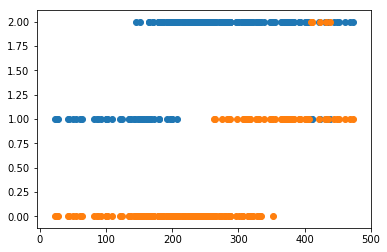

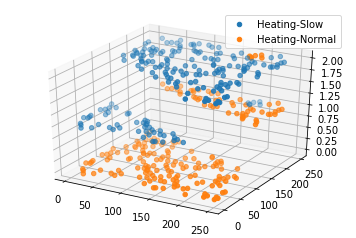

In [210]:
from mpl_toolkits.mplot3d import Axes3D
tm = "Heating-Slow"
plt.scatter((dfcum["P1"] + dfcum["P2"]), dfcum[tm])
tm = "Heating-Normal"
plt.scatter((dfcum["P1"] + dfcum["P2"]), dfcum[tm])

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.scatter(np.array(dfcum["P1"]), np.array(dfcum["P2"].tolist()), np.array(dfcum["None-None"].tolist())/10)
ax.scatter(np.array(dfcum["P1"]), np.array(dfcum["P2"].tolist()), np.array(dfcum["Heating-Slow"].tolist()), label="Heating-Slow")
ax.scatter(np.array(dfcum["P1"]), np.array(dfcum["P2"].tolist()), np.array(dfcum["Heating-Normal"].tolist()), label="Heating-Normal")
ax.legend()
#for angle in range(0, 360):
#    ax.view_init(0, 90)


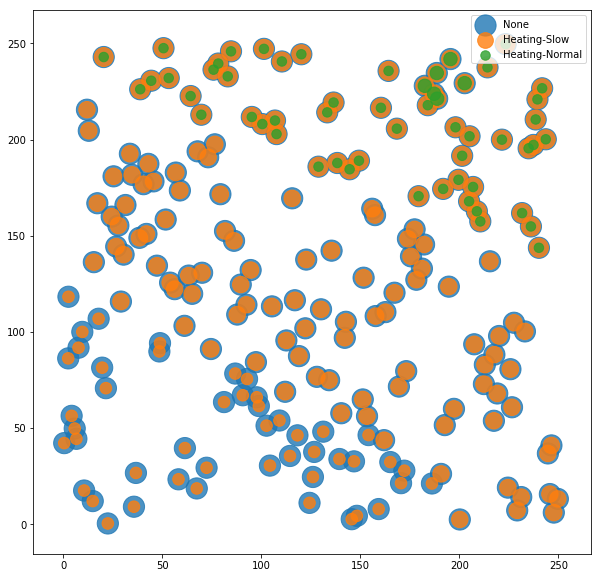

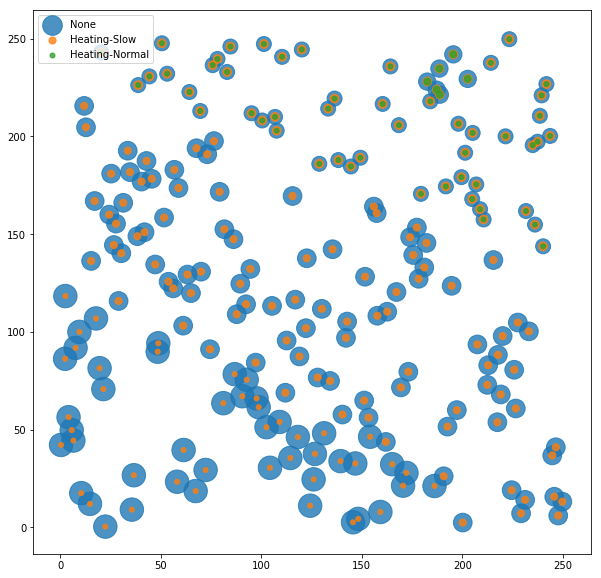

In [219]:
j = "Heater"
lam = 15
a = 0.8
plt.figure(figsize=(10,10))
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["None-None"] 
                                             + dfcum["Heating-Slow"]*stn.p["Heating", j, "Slow"] 
                                             + dfcum["Heating-Normal"]*stn.p["Heating", j, "Normal"])),
            alpha=a, label="None")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Heating-Slow"]*stn.p["Heating", j, "Slow"] 
                                             + dfcum["Heating-Normal"]*stn.p["Heating", j, "Normal"])),
            alpha=a, label="Heating-Slow")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Heating-Normal"]*stn.p["Heating", j, "Normal"])),
            alpha=a, label="Heating-Normal")
plt.legend()
plt.show()
lam = 25
plt.figure(figsize=(10,10))
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["None-None"] 
                                             + dfcum["Heating-Slow"]
                                             + dfcum["Heating-Normal"])), alpha=a, label="None")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Heating-Slow"] 
                                             + dfcum["Heating-Normal"])), alpha=a, label="Heating-Slow")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Heating-Normal"])), alpha=a, label="Heating-Normal")
plt.legend()
plt.show()

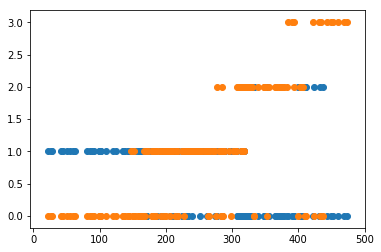

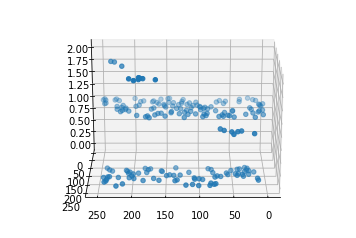

In [90]:
import collections
tms = set(np.unique(prof["taskmode"]))
N = len(np.unique(prof["id"]))
data = {tm:[] for tm in tms}
data = {**data, **{p:[] for p in stn.products}}
j = "Reactor"
profj = prof[prof["unit"] == j]
for rid in np.unique(prof["id"]):
    c = collections.Counter(profj.loc[profj["id"] == rid,"taskmode"])
    for k in c:
        data[k].append(c[k])
    for k in tms - set(c):
        data[k].append(0)
    for p in stn.products:
        data[p].append(prof.loc[prof["id"] == rid, p][0])
dfcum = pd.DataFrame(data=data)

from mpl_toolkits.mplot3d import Axes3D
tm = "Reaction_1-Slow"
plt.scatter((dfcum["P1"] + dfcum["P2"]), dfcum[tm])
tm = "Reaction_1-Normal"
plt.scatter((dfcum["P1"] + dfcum["P2"]), dfcum[tm])

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.scatter(np.array(dfcum["P1"]), np.array(dfcum["P2"].tolist()), np.array(dfcum["None-None"].tolist())/10)
ax.scatter(np.array(dfcum["P1"]), np.array(dfcum["P2"].tolist()), np.array(dfcum["Reaction_1-Slow"].tolist()))
#ax.scatter(np.array(dfcum["P1"]), np.array(dfcum["P2"].tolist()), np.array(dfcum["Reaction_1-Normal"].tolist()))
for angle in range(0, 360):
    ax.view_init(20, 90)


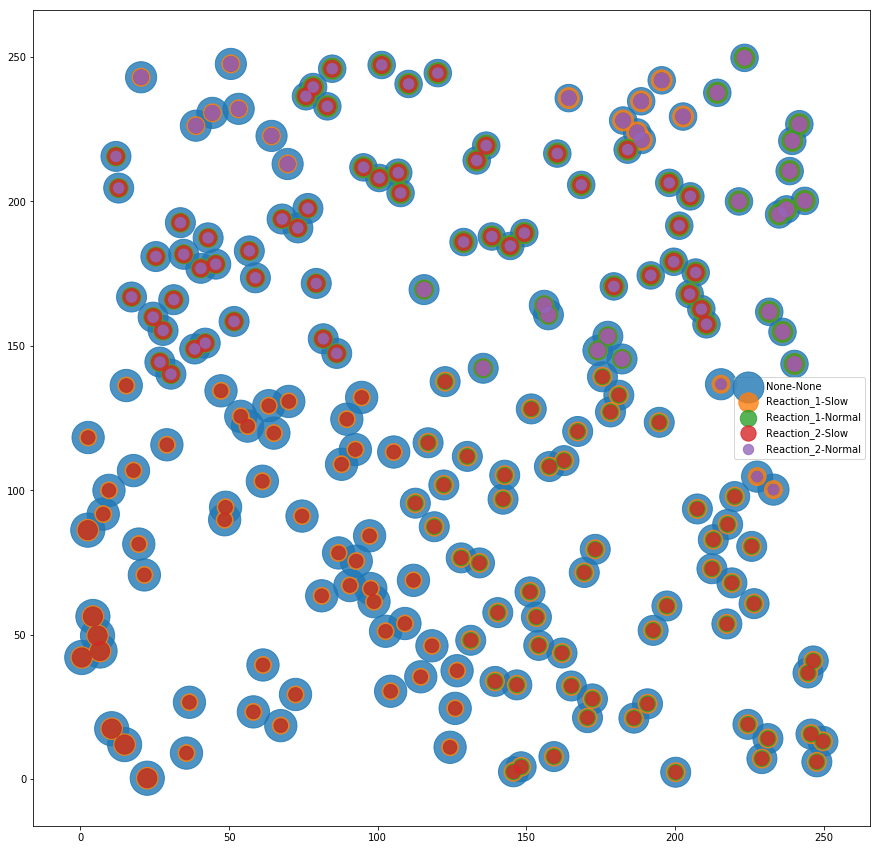

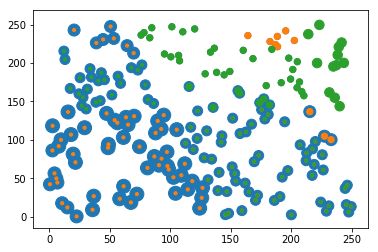

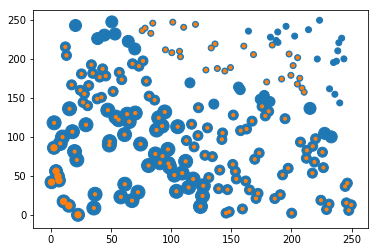

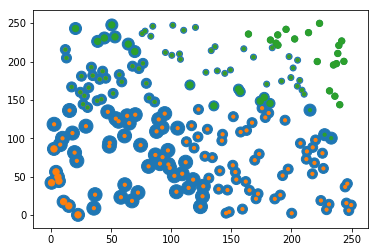

,Heating-Normal,Heating-Slow,None-None,P1,P2,Reaction_1-Normal,Reaction_1-Slow,Reaction_2-Normal,Reaction_2-Slow
71,0,0,13,22.500269,0.326383,0,1,0,2


In [91]:
lam = 18
a = 0.8
plt.figure(figsize=(15, 15))
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["None-None"]*3
                                              + dfcum["Reaction_1-Slow"]*stn.p["Reaction_1", j, "Slow"]
                                              + dfcum["Reaction_1-Normal"]*stn.p["Reaction_1", j, "Normal"]
                                              + dfcum["Reaction_2-Slow"]*stn.p["Reaction_2", j, "Slow"]
                                              + dfcum["Reaction_2-Normal"]*stn.p["Reaction_2", j, "Normal"]))
            , alpha=a, label="None-None")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_1-Slow"]*stn.p["Reaction_1", j, "Slow"]
                                              + dfcum["Reaction_1-Normal"]*stn.p["Reaction_1", j, "Normal"]
                                              + dfcum["Reaction_2-Slow"]*stn.p["Reaction_2", j, "Slow"]
                                              + dfcum["Reaction_2-Normal"]*stn.p["Reaction_2", j, "Normal"])),
            alpha=a, label="Reaction_1-Slow")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_1-Normal"]*stn.p["Reaction_1", j, "Normal"]
                                              + dfcum["Reaction_2-Slow"]*stn.p["Reaction_2", j, "Slow"]
                                              + dfcum["Reaction_2-Normal"]*stn.p["Reaction_2", j, "Normal"])),
            alpha=a, label="Reaction_1-Normal")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_2-Slow"]*stn.p["Reaction_2", j, "Slow"]
                                              + dfcum["Reaction_2-Normal"]*stn.p["Reaction_2", j, "Normal"])),
            alpha=a, label="Reaction_2-Slow")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_2-Normal"]*stn.p["Reaction_2", j, "Normal"])),
            alpha=a, label="Reaction_2-Normal")
plt.legend()
plt.show()
plt.scatter(dfcum["P1"], dfcum["P2"], s=((dfcum["None-None"]**2)), alpha=1)
plt.scatter(dfcum["P1"], dfcum["P2"], s=(10*(dfcum["Reaction_1-Slow"]**2)), alpha=1)
plt.scatter(dfcum["P1"], dfcum["P2"], s=(10*(dfcum["Reaction_1-Normal"]**2)), alpha=1)
plt.show()
plt.scatter(dfcum["P1"], dfcum["P2"], s=((dfcum["None-None"]**2)), alpha=1)
plt.scatter(dfcum["P1"], dfcum["P2"], s=(10*(dfcum["Reaction_2-Slow"]**2)), alpha=1)
plt.show()
plt.scatter(dfcum["P1"], dfcum["P2"], s=((dfcum["None-None"]**2)), alpha=1)
plt.scatter(dfcum["P1"], dfcum["P2"], s=(10*(dfcum["Reaction_2-Slow"]**2)), alpha=1)
plt.scatter(dfcum["P1"], dfcum["P2"], s=(10*(dfcum["Reaction_2-Normal"]**2)), alpha=1)
plt.show()
dfcum[dfcum["P1"] + dfcum["P2"] == min(dfcum["P1"] + dfcum["P2"])]


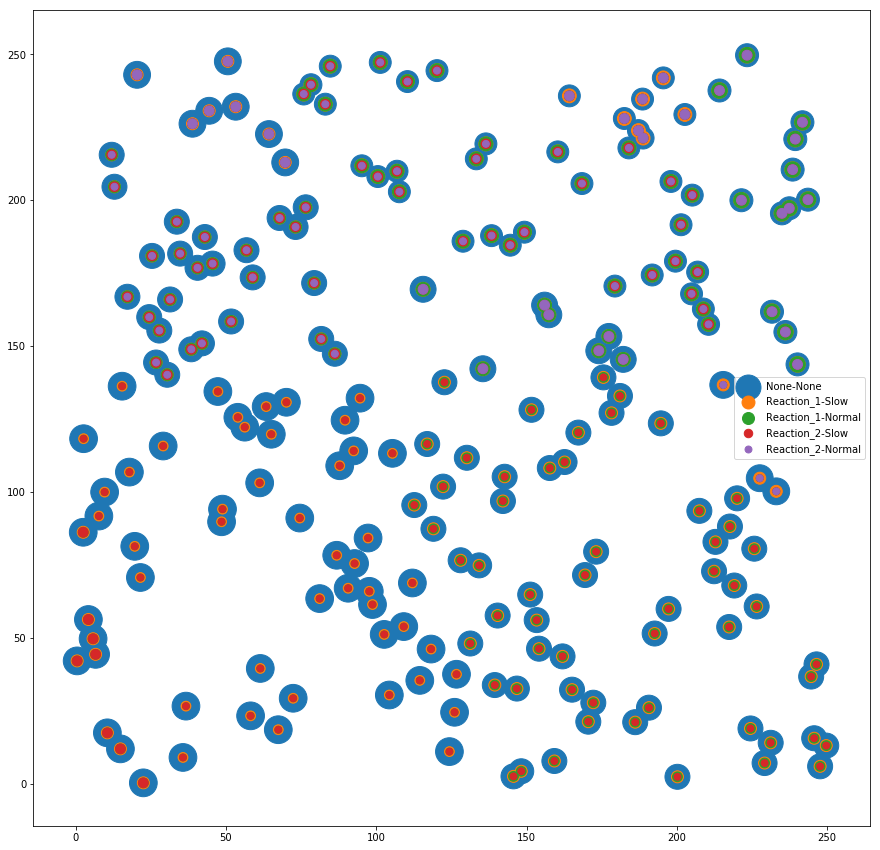

In [101]:
lam = 48
plt.figure(figsize=(15, 15))
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["None-None"]
                                              + dfcum["Reaction_1-Slow"]
                                              + dfcum["Reaction_1-Normal"]
                                              + dfcum["Reaction_2-Slow"]
                                              + dfcum["Reaction_2-Normal"]))
            , alpha=1, label="None-None")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_1-Slow"]
                                              + dfcum["Reaction_1-Normal"]
                                              + dfcum["Reaction_2-Slow"]
                                              + dfcum["Reaction_2-Normal"])),
            alpha=1, label="Reaction_1-Slow")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_1-Normal"]
                                              + dfcum["Reaction_2-Slow"]
                                              + dfcum["Reaction_2-Normal"])),
            alpha=1, label="Reaction_1-Normal")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_2-Slow"]
                                              + dfcum["Reaction_2-Normal"])),
            alpha=1, label="Reaction_2-Slow")
plt.scatter(dfcum["P1"], dfcum["P2"], s=(lam*(dfcum["Reaction_2-Normal"])),
            alpha=1, label="Reaction_2-Normal")
plt.legend()
plt.show()

In [224]:
dfj = prof[prof["unit"] == "Reactor"].copy()
dfj = dfj.reset_index(drop=True)
tms = np.unique(dfj["taskmode"])
cols = stn.products+list(tms)
dfhist = pd.DataFrame(columns=cols)
ids = np.unique(dfj["id"])
for rid in ids:
    c = collections.Counter(dfj.loc[dfj["id"] == rid, "taskmode"])
    counts = [c[tm] for tm in tms]
    dfjid = dfj[dfj["id"] == rid]
    prods = list(dfjid.loc[dfjid.index[0], stn.products])
    line = prods + counts
    dfhist = dfhist.append(pd.DataFrame([line], columns=cols))
X = dfhist[stn.products]
tm = "None-None"
y = np.array(dfhist[tm])
y = y.astype(str)
if len(np.unique(y)) > 2:
    logreg = linear_model.LogisticRegression(C=1, multi_class="multinomial",
                                             solver="newton-cg", verbose=0, max_iter=1000000)
else:
    logreg = linear_model.LogisticRegression(C=1, max_iter=1000000)
logreg.fit(X, y)



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
k = 10
dem = [50, 50]
res.head()
res = res.reset_index(drop=True)
dis = sum([(res[p] - dem[i])**2 for i, p in enumerate(stn.products)])
neighbours = tuple(res.loc[dis.nsmallest(5).index, "id"])
df = prof[prof["id"].isin(neighbours)].copy()
get_trans_prob(df, "None-None", "Heater")

prof[stn.products + ["id"]].drop_duplicates() 

(105, 9)


,P1,P2,id
0,15.434457,136.246977,0
0,217.431710,53.733342,1
0,70.098010,130.741468,2
0,206.932591,175.353900,3
0,164.254707,235.738010,4
0,74.547793,91.062628,5
0,97.273228,84.222871,6
0,7.697406,91.748476,7
0,67.836824,193.886543,8
0,115.587772,169.454248,9
